MSE of Raker is  0.028637841279105763
MSE of OMKL-GF is  0.024366359111801916
MSE of VAW^2 is  0.02280178319099573
MSE of VAW^2 with truncated expert predictions is  0.02278371143434926
MSE of VAW-AGGR is  0.026740754306594384
MSE of VAW-EWA is  0.02760702274116243
MSE of VAW-BOA is  0.026418250702861402
MSE of VAW-ML-Poly is  0.026104601351334973
MSE of VAW-ML-Prod is  0.02627206428816304


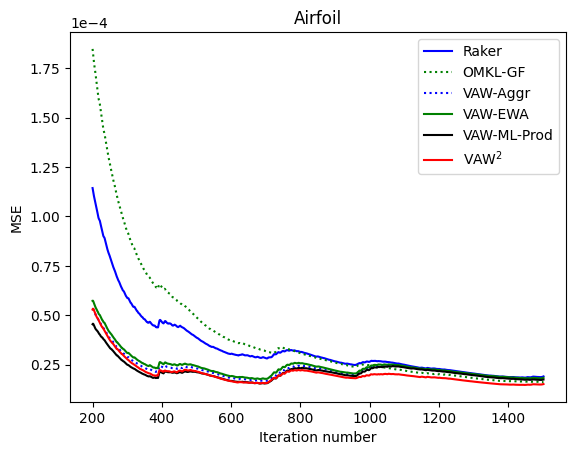

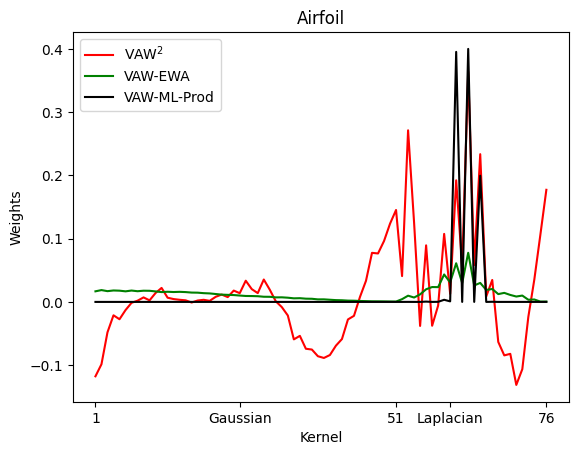

In [3]:
from opera import Mixture
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error as MSE
from numpy import linalg as LA
from copy import copy
from opera import Mixture
from matplotlib.ticker import ScalarFormatter
from mkl_algorithms import Raker
from mkl_algorithms import OMKLGF


data = np.genfromtxt('airfoil_self_noise.dat')
X = data[:,:-1]
Y = data[:,-1:]

# Normalizing the target vector Y
Y = (Y / (np.max(Y) - np.min(Y))) - np.min(Y) / (np.max(Y) - np.min(Y))

# Normalizing the feature matrix X
M, N = X.shape
X_norms = np.linalg.norm(X, axis=1) #Calculate the norms of each row
X = X / np.max(X_norms) # Divide each row by the maximum norm

# Creating lists of gammas and kernels for feature transformation
gamma = []
kernel_list = []
num_rbf = 51
for i in range(num_rbf):
    gamma.append(10 ** (4 * (i / 50) - 2))
    kernel_list.append('Gaussian')
num_lap = 25
for i in range(num_lap):
    gamma.append(10 ** ((i / 6) - 2))
    kernel_list.append('Laplacian')
gamma = np.array(gamma)
n_components = 50  # Number of random features per kernel
P = num_rbf + num_lap  # Total number of kernels

# Initialize lists to store MSE, predictions and weights for different algorithms
mse_vaw2 = []
mse_vaw2_trunc = []
mse_aggr = []
mse_ewaf = []
mse_boa = []
mse_mlpol = []
mse_mlprod = []
mse_omkl = []
mse_raker = []



cc_predictions_vaw2 = np.zeros((5, Y.shape[0]))
cc_predictions_aggr = np.zeros((5, Y.shape[0]))
cc_prediction_ewa_05 = np.zeros((5, Y.shape[0]))
cc_predictions_boa = np.zeros((5, Y.shape[0]))
cc_predictions_mlpol = np.zeros((5, Y.shape[0]))
cc_predictions_mlprod = np.zeros((5, Y.shape[0]))
cc_predictions_omkl = []
cc_predictions_raker = []


cc_mse_vaw2 = np.zeros((5, Y.shape[0]))
cc_mse_aggr = np.zeros((5, Y.shape[0]))
cc_mse_ewa_05 = np.zeros((5, Y.shape[0]))
cc_mse_boa = np.zeros((5, Y.shape[0]))
cc_mse_mlpol = np.zeros((5, Y.shape[0]))
cc_mse_mlprod = np.zeros((5, Y.shape[0]))
cc_mse_omkl = np.zeros((5, Y.shape[0]))
cc_mse_raker = np.zeros((5, Y.shape[0]))


weights_vaw2 = np.zeros((5, P))
weights_ewa = np.zeros((5, P))
weights_mlprod = np.zeros((5, P))


def generate_random_features_dict_ran(X, ran_feature, gamma, kernel_list):
    """
    Generates random features using Fourier features with given kernels and gammas.

    Args:
        X (np.ndarray): Feature matrix.
        ran_feature (np.ndarray): Random feature matrix.
        gamma (np.ndarray): Gamma values for kernels.
        kernel_list (list): List of kernel names.

    Returns:
        dict: Dictionary of random features for each kernel.
    """
    M, N = X.shape
    _, n_components, b = ran_feature.shape

    random_features = {}

    for i, kernel_type in enumerate(kernel_list):
        features = np.zeros((M, n_components * 2))  # Features for current kernel
        for j in range(M):
            X_f = X[j:j + 1, :].dot(ran_feature[:, :, i])
            features[j, :] = (1 / np.sqrt(n_components)) * np.concatenate((np.sin(X_f), np.cos(X_f)), axis=1)
        random_features[f"{kernel_type}_{i}"] = features

    return random_features

def vaw_forecaster(features, target, lambda_reg=1, weights=None):

    """
    Vovk-Azoury-Warmuth forecaster with closed-form solution using Sherman-Morrison update.

    Args:
        features (np.ndarray): Feature matrix, where each row is a feature vector (shape: n_samples, n_features).
        target (np.ndarray): Target vector, with target values (shape: n_samples).
        lambda_reg (float): Regularization parameter (default: 1.0).
        weights (np.ndarray): Initial weights vector (default: None, initialized to zeros).

    Returns:
        tuple: predictions, rmse_history, updated weights.
    """

    n_samples, n_features = features.shape
    predictions = []
    rmse_history = []  # To store RMSE at each horizon
    squared_errors_cumulative = 0  # Cumulative squared errors

    # Initialize weights if not provided, else use provided weights
    if weights is None:
        weights = np.zeros(n_features)

    # Initialize the inverse of (lambda * I + sum of zi zi^T), using first the value lambda * I
    reg_matrix_inverse = (1/lambda_reg) * np.eye(n_features) # S^-1

    # Initialize w, which is the result of sum(yizi)
    sum_yizi = np.zeros(n_features)

    for t in range(n_samples):
        zt = features[t]  # Current feature vector
        yt = target[t]    # Current target value

        # Compute the prediction, since x_t = reg_matrix_inverse * sum_yizi
        if t==0:
             prediction = 0
        else:
            prediction = np.dot(sum_yizi, reg_matrix_inverse @ zt) # This is xt^T * zt

        predictions.append(prediction)

        # Compute squared error
        squared_error = (yt - prediction) ** 2
        squared_errors_cumulative += squared_error

        # Calculate RMSE up to the current horizon
        rmse_t = np.sqrt(squared_errors_cumulative / (t + 1))
        rmse_history.append(rmse_t)

        # Update sum_yizi
        sum_yizi += yt*zt

        # Update the inverse matrix using Sherman-Morrison formula:
        # S_t = S_{t-1} + z_t z_t^T
        # S_t^-1 = S_{t-1}^-1 - (S_{t-1}^-1 @ z_t @ z_t^T @ S_{t-1}^-1) / (1 + z_t^T @ S_{t-1}^-1 @ z_t)
        zt = zt.reshape(-1, 1) # Convert to a column vector
        numerator = reg_matrix_inverse @ zt @ zt.T @ reg_matrix_inverse
        denominator = 1 + zt.T @ reg_matrix_inverse @ zt
        reg_matrix_inverse = reg_matrix_inverse - (numerator/ denominator[0,0])

    # Get the last weight vector
    if n_samples == 0:
        weights = np.zeros(n_features)
    else:
        weights = reg_matrix_inverse @ sum_yizi

    return predictions, rmse_history, weights

def quadratic_loss_gradient(w, x_i, y_i):
    """
    Computes the gradient of the quadratic loss function.

    Args:
        w (np.ndarray): Weight vector.
        x_i (np.ndarray): Input feature vector.
        y_i (float): Target value.

    Returns:
        np.ndarray: Gradient of the loss function.
    """
    return 2 * (np.dot(w, x_i) - y_i) * x_i

def online_gradient_descent(X, y, learning_rates=None, initial_w=None):
    """
    Implements online gradient descent.

    Args:
        X (np.ndarray): Feature matrix. Shape (m, n).
        y (np.ndarray): Target vector. Shape (m,).
        learning_rates (list or np.ndarray): Learning rates (eta_t). If None, uses 1/m.
        initial_w (np.ndarray): Initial weight vector. If None, uses a vector of zeros.

    Returns:
        tuple: (w, predictions), where w is the array of weights w_t, predictions is the array of predictions.

    Raises:
        ValueError: If the lengths of X and y do not match.
    """
    if len(X) != len(y):
        raise ValueError("Lengths of X and y must match.")

    m = len(y)  # Number of samples
    n = X.shape[1] if X.ndim > 1 else 1  # Number of features

    if initial_w is None:
        initial_w = np.zeros(n)
    else:
        if len(initial_w) != n:
            raise ValueError("Dimension of initial_w must match the number of features")

    if learning_rates == 'descending':
        learning_rates = [0.1 / np.sqrt(t + 1) for t in range(m)]
    elif learning_rates is None:
        learning_rates = np.full(m, 1/m) #Default learning rate
    else:
        learning_rates = np.full(m, learning_rates) #If learning_rates is a single value, use it for all steps.

    if X.ndim == 1:
        X = X.reshape(-1, 1)  # Convert X to a 2D array

    w = np.zeros((m, n))
    w[0] = initial_w.copy()
    predictions = np.zeros(m)

    for t in range(m - 1):
        predictions[t] = np.dot(w[t], X[t]) if w[t].ndim == 1 else np.dot(w[t], X[t].reshape(-1, 1))
        gradient = quadratic_loss_gradient(w[t], X[t], y[t])
        w[t + 1] = w[t] - learning_rates[t] * gradient
    predictions[m - 1] = np.dot(w[m - 1], X[m - 1]) if w[m - 1].ndim == 1 else np.dot(w[m - 1], X[m - 1].reshape(-1, 1))

    return w, predictions

# Generating expert predictions using VAW on transformed features
all_predictions_df_lst = []
for cc in range(5):
    np.random.seed(cc)
    ran_feature = np.zeros((N, n_components, gamma.shape[0]))
    for i in range(num_rbf):
        ran_feature[:, :, i] = np.random.randn(N, n_components) * np.sqrt(1 / gamma[i])
    for i in range(num_lap):
        ran_feature[:, :, i + num_rbf] = np.random.standard_cauchy((N, n_components)) * (1 / gamma[i + num_rbf])
    fourier_features = generate_random_features_dict_ran(X, ran_feature, gamma, kernel_list)
    all_predictions_df = pd.DataFrame()
    rmse_individual = []
    for kernel_name, features in fourier_features.items():
        predictions, rmse_history, _ = vaw_forecaster(
            fourier_features[kernel_name],
            Y,
            lambda_reg=1.
        )
        rmse_individual.append(rmse_history[-1])
        predictions_df = pd.DataFrame(predictions, columns=[kernel_name])
        all_predictions_df = pd.concat([all_predictions_df, predictions_df], axis=1)
    all_predictions_df_lst.append(all_predictions_df)

# Truncating expert predictions to the range of Y
all_predictions_df_lst_trunc = [df.map(lambda u: min(max(u, 0), 1)) for df in copy(all_predictions_df_lst)]

#Raker
lam = .001

for cc in range(0,5):
    np.random.seed(cc)
    # Generating Random Features
    ran_feature = np.zeros((N,n_components,gamma.shape[0]))
    for i in range(0,num_rbf):
        ran_feature[:,:,i] = np.random.randn(N,n_components)*np.sqrt(1/gamma[i])
    for i in range(0,num_lap):
        ran_feature[:,:,i+num_rbf] = np.random.standard_cauchy((N,n_components))*(1/gamma[i+num_rbf])

    e = np.zeros((M,1))
    w = np.ones((1,gamma.shape[0]))
    theta = np.zeros((2*n_components,gamma.shape[0]))
    predictions = []
    for i in range(0,M):
        eta = .1/np.sqrt(i+1)
        raker = Raker(lam, ran_feature, eta)
        f_RF, f_RF_p, X_features = raker.predict(X[i:i+1,:], theta, w)
        w, theta = raker.update(f_RF_p, Y[i], theta, w, X_features)
        predictions.append(f_RF)
    try:
      mse_raker.append(MSE(np.array(predictions).ravel(), Y))
    except ValueError:
        continue
    cc_predictions_raker.append(predictions)
cc_predictions_raker = np.array(cc_predictions_raker)


#OMKL-GF
for cc in range(0,5):
    np.random.seed(cc)
    # Generating Random Features
    ran_feature = np.zeros((N,n_components,gamma.shape[0]))
    for i in range(0,num_rbf):
        ran_feature[:,:,i] = np.random.randn(N,n_components)*np.sqrt(1/gamma[i])
    for i in range(0,num_lap):
        ran_feature[:,:,i+num_rbf] = np.random.standard_cauchy((N,n_components))*(1/gamma[i+num_rbf])

    # OMKL-GF with M = 5 and J = 2
    e = np.zeros((M,1))
    w = np.ones((1,gamma.shape[0]))
    theta = np.zeros((2*n_components,gamma.shape[0]))
    m = 5
    J = 2
    ter = 0
    p_c = np.zeros((1,J))
    A_t = np.zeros((gamma.shape[0],J))
    q = np.zeros((gamma.shape[0],1))
    predictions = []
    for i in range(0,M):
        eta = .1/np.sqrt(i+1)
        omklgf = OMKLGF(lam, ran_feature, gamma, eta, eta, m, J)
        if ter == 0:
            A_t, p_kk = omklgf.graph_gen(w)
        f_RF, f_RF_p, X_features, n_n, p_c, I_t = omklgf.predict(X[i:i+1,:], theta, w, A_t)
        w, theta = omklgf.update(f_RF_p, Y[i], theta, w, X_features, n_n, p_kk, p_c, ter)
        predictions.append(f_RF)
        if i>300:
            ter = 1
        try:
          mse_omkl.append(MSE(np.array(predictions).ravel(), Y))
        except ValueError:
            continue
    cc_predictions_omkl.append(predictions)
cc_predictions_omkl = np.array(cc_predictions_omkl)

# VAW^2 algorithm
for cc in range(5):
    predictions, _, weights_vaw2[cc] = vaw_forecaster(np.array(all_predictions_df_lst[cc]), Y, lambda_reg=1.)
    cc_predictions_vaw2[cc] = predictions
    mse_vaw2.append(MSE(predictions, Y))

# VAW^2 algorithm (with truncated expert predictions)

for cc in range(5):
    predictions, _, weights_vaw2[cc] = vaw_forecaster(np.array(all_predictions_df_lst_trunc[cc]), Y, lambda_reg=1.)
    mse_vaw2_trunc.append(MSE(predictions, Y))

# Aggregating algorithm of Vovk
for cc in range(5):
    x_data = all_predictions_df_lst_trunc[cc].values
    y_data = Y
    w_out = np.zeros((M, P))  # Initialize weights for inner and outer VAW algorithms
    eta = 2

    # Define the loss function
    loss = lambda y1, y2: (y1 - y2) ** 2

    # Cumulative losses of N experts
    L = np.zeros((P, M))
    # Predictions of the cumulative algorithm
    prediction = np.zeros(M)
    # Potential
    r = np.zeros(M)

    for t in range(M - 1):
        loss_experts_1 = loss(x_data[t + 1], np.ones(P)) # loss when r = 1
        loss_experts_0 = loss(x_data[t + 1], np.zeros(P)) # loss when r = 0

        r[t + 1] = 0.5 + (1 / (2 * eta)) * np.log(
            np.sum(np.exp(-eta * L[:, t] - eta * loss_experts_1)) / np.sum(np.exp(-eta * L[:, t] - eta * loss_experts_0))
        )

        if r[t + 1] < 0:
            prediction[t + 1] = 0
        elif 0 <= r[t + 1] <= 1:
            prediction[t + 1] = r[t + 1]
        else:
            prediction[t + 1] = 1

        L[:, t + 1] = L[:, t] + loss(x_data[t + 1], np.tile(y_data[t + 1], P))
    try:
        mse_aggr.append(MSE(prediction, y_data))
    except ValueError:
        continue
    cc_predictions_aggr[cc] = prediction

# VAW-EWA algorithm
eta = 0.5
for cc in range(5):
    x_data = all_predictions_df_lst_trunc[cc].values
    y_data = Y

    w_out = np.zeros((M, P))  # Initialize weights

    # Define the loss function
    loss = lambda y1, y2: (y1 - y2) ** 2

    # Cumulative losses of N experts
    L = np.zeros((P, M))
    # Predictions of the cumulative algorithm
    prediction = np.zeros(M)
    # Potential
    r = np.zeros(M)

    for t in range(M - 1):

        # EWA prediction
        prediction[t + 1] = np.sum(np.exp(-eta * L[:, t]) * x_data[t + 1]) / np.sum(np.exp(-eta * L[:, t]))

        L[:, t + 1] = L[:, t] + loss(x_data[t + 1], np.tile(y_data[t + 1], P))
    weights_ewa[cc] = (np.exp(-eta * L[:, -1]) / np.sum(np.exp(-eta * L[:, -1])))
    try:
        mse_ewaf.append(MSE(prediction, y_data))
    except ValueError:
        continue
    cc_prediction_ewa_05[cc] = prediction

# VAW-BOA algorithm
for cc in range(5):
    model = 'BOA'
    mod_opera = Mixture(
        y=Y.ravel(),
        experts=all_predictions_df_lst_trunc[cc],
        model=model,
        loss_type="mse",
        loss_gradient=False,
    )
    try:
        mse_boa.append(MSE(Y, mod_opera.predictions))
    except ValueError:
        continue
    cc_predictions_boa[cc] = mod_opera.predictions

# VAW-ML-Poly algorithm
for cc in range(5):
    model = 'MLpol'
    mod_opera = Mixture(
        y=Y.ravel(),
        experts=all_predictions_df_lst_trunc[cc],
        model=model,
        loss_type="mse",
        loss_gradient=False,
    )
    try:
        mse_mlpol.append(MSE(Y, mod_opera.predictions))
    except ValueError:
        continue
    cc_predictions_mlpol[cc] = mod_opera.predictions

# VAW-ML-Prod algorithm
for cc in range(5):
    model = 'MLprod'
    mod_opera = Mixture(
        y=Y.ravel(),
        experts=all_predictions_df_lst_trunc[cc],
        model=model,
        loss_type="mse",
        loss_gradient=False,
    )
    weights_mlprod[cc] = mod_opera.w
    try:
        mse_mlprod.append(MSE(Y, mod_opera.predictions))
    except ValueError:
        continue
    cc_predictions_mlprod[cc] = mod_opera.predictions

# Calculate cumulative MSE for each algorithm
for cc in range(5):
    for t in range(Y.shape[0]):
        cc_mse_vaw2[cc, t] = 1. / (t + 1) * MSE(cc_predictions_vaw2[cc][:t + 1], Y[:t + 1])
        cc_mse_aggr[cc, t] = 1. / (t + 1) * MSE(cc_predictions_aggr[cc][:t + 1], Y[:t + 1])
        cc_mse_ewa_05[cc, t] = 1. / (t + 1) * MSE(cc_prediction_ewa_05[cc][:t + 1], Y[:t + 1])
        cc_mse_boa[cc, t] = 1. / (t + 1) * MSE(cc_predictions_boa[cc][:t + 1], Y[:t + 1])
        cc_mse_mlpol[cc, t] = 1. / (t + 1) * MSE(cc_predictions_mlpol[cc][:t + 1], Y[:t + 1])
        cc_mse_mlprod[cc, t] = 1. / (t + 1) * MSE(cc_predictions_mlprod[cc][:t + 1], Y[:t + 1])
        cc_mse_omkl[cc, t] = 1./(t+1)*MSE(cc_predictions_omkl[cc][:t+1].ravel(), Y[:t+1])
        cc_mse_raker[cc, t] = 1./(t+1)*MSE(cc_predictions_raker[cc][:t+1].ravel(), Y[:t+1])

# Calculate mean cumulative MSE across all repetitions
cc_mse_vaw2 = np.mean(cc_mse_vaw2, axis=0)
cc_mse_aggr = np.mean(cc_mse_aggr, axis=0)
cc_mse_ewa_05 = np.mean(cc_mse_ewa_05, axis=0)
cc_mse_boa = np.mean(cc_mse_boa, axis=0)
cc_mse_mlpol = np.mean(cc_mse_mlpol, axis=0)
cc_mse_mlprod = np.mean(cc_mse_mlprod, axis=0)
cc_mse_omkl = np.mean(cc_mse_omkl, axis = 0)
cc_mse_raker = np.mean(cc_mse_raker, axis = 0)

# Print final MSE values
print('MSE of Raker is ', np.mean(mse_raker))
print('MSE of OMKL-GF is ', np.mean(mse_omkl))
print('MSE of VAW^2 is ', np.mean(mse_vaw2))
print('MSE of VAW^2 with truncated expert predictions is ', np.mean(mse_vaw2_trunc))
print('MSE of VAW-AGGR is ', np.mean(mse_aggr))
print('MSE of VAW-EWA is ', np.mean(mse_ewaf))
print('MSE of VAW-BOA is ', np.mean(mse_boa))
print('MSE of VAW-ML-Poly is ', np.mean(mse_mlpol))
print('MSE of VAW-ML-Prod is ', np.mean(mse_mlprod))


# Plotting cumulative MSE for different algorithms
start_index = 200
fig1 = plt.figure(1)
ax = fig1.add_subplot()
plt.title('Airfoil')
plt.xlabel('Iteration number')
plt.ylabel('MSE')
sf = ScalarFormatter()
sf.set_powerlimits((-4, 4))
ax.yaxis.set_major_formatter(sf)
ax.plot(np.arange(start_index, Y.shape[0]), cc_mse_raker[start_index:], 'b', label = 'Raker')
ax.plot(np.arange(start_index, Y.shape[0]), cc_mse_omkl[start_index:], 'g:', label = 'OMKL-GF')
ax.plot(np.arange(start_index, Y.shape[0]), cc_mse_aggr[start_index:], 'b:', label='VAW-Aggr')
ax.plot(np.arange(start_index, Y.shape[0]), cc_mse_ewa_05[start_index:], 'g', label='VAW-EWA')
ax.plot(np.arange(start_index, Y.shape[0]), cc_mse_mlprod[start_index:], 'k', label='VAW-ML-Prod')
ax.plot(np.arange(start_index, Y.shape[0]), cc_mse_vaw2[start_index:], 'r', label=r'VAW$^2$')
plt.legend()
plt.show()

# Plotting weights of different algorithms
fig2 = plt.figure(2)
ax = fig2.add_subplot()
P = num_rbf + num_lap
ax.plot(np.arange(1, P + 1), np.mean(weights_vaw2, axis = 0), 'r', label=r'VAW$^2$')
ax.plot(np.arange(1, P + 1), np.mean(weights_ewa, axis = 0), 'g', label='VAW-EWA')
ax.plot(np.arange(1, P + 1), np.mean(weights_mlprod, axis = 0), 'k', label='VAW-ML-Prod')

plt.legend()
plt.xlabel('Kernel')
plt.ylabel('Weights')
# Adding kernel numbers and names to the x-axis
x_ticks = [1, 51, P]  # Kernel numbers to display
x_labels = [str(tick) for tick in x_ticks]  # Convert kernel numbers to strings

# Adding kernel names
x_ticks_labels = [25, 60]  # Positions for kernel names
x_labels_labels = ['Gaussian', 'Laplacian']  # Kernel names

# Combining kernel numbers and names for x-axis ticks
all_ticks = sorted(list(set(x_ticks + x_ticks_labels)))
all_labels = []

# Creating labels for all ticks
for tick in all_ticks:
    if tick in x_ticks:
        all_labels.append(str(tick))  # Add kernel number
    elif tick in x_ticks_labels:
        all_labels.append(x_labels_labels[x_ticks_labels.index(tick)])  # Add kernel name

plt.xticks(all_ticks, all_labels)
plt.title('Airfoil')
plt.show()